In [82]:
import backtrader as bt
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import backtrader.plot

#https://algotrading101.com/learn/backtrader-for-backtesting/ 

In [83]:
# Create a Stratey class, that inherits the Backtrader strategy class
class TestStrategy(bt.Strategy):

    path = os.path.abspath("data/Predicted_mu.csv")
    df = pd.read_csv(path)
    mu = 0

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function for this strategy'''
        
        # if doprint:
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        self.dataopen = self.datas[0].open

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.mu = TestStrategy.df.Predicted_Values

    def notify_order(self, order):
            if order.status in [order.Submitted, order.Accepted]:
                # Buy/Sell order submitted/accepted to/by broker - Nothing to do
                return
            # Check if an order has been completed
            # Attention: broker could reject order if not enough cash
            if order.status in [order.Completed]:
                if order.isbuy():
                    self.log(
                        'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                        (order.executed.price,
                        order.executed.value,
                        order.executed.comm))
                    self.buyprice = order.executed.price
                    self.buycomm = order.executed.comm
                else:  # Sell
                    self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                            (order.executed.price,
                            order.executed.value,
                            order.executed.comm))
                self.bar_executed = len(self)
            elif order.status in [order.Canceled, order.Margin, order.Rejected]:
                self.log('Order Canceled/Margin/Rejected')
            # Write down: no pending order
            self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])
        
        print(self.mu[0])
        if self.mu[0] > 0:

            # BUY, BUY, BUY!!! (with all possible default parameters)
            self.log('BUY CREATE, %.2f' % self.dataopen[0])
            # Keep track of the created order to avoid a 2nd order
            self.order = self.buy()


            self.log('SELL CREATE, %.2f' % self.dataclose[0])
            self.order = self.sell()

        self.mu = self.mu.drop(0).reset_index().Predicted_Values

        #return

def stop(self):
    self.log('Ending Value %.2f' %
                (self.broker.getvalue()), doprint=True)


In [84]:
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    path = os.path.abspath("data/Predicted_mu.csv")
    df = pd.read_csv(path)

    # Add a strategy
    # strats = cerebro.optstrategy(
    #     TestStrategy)
    cerebro.addstrategy(TestStrategy)

    # Datas are in a subfolder of the samples. Need to find where the script is
    # because it could have been called from anywhere
    datapath = os.path.abspath("data/SPY.csv")

    # Create a Data Feed
    data = bt.feeds.YahooFinanceCSVData(
        dataname=datapath,
        # Do not pass values before this date
        fromdate=datetime.datetime(2021, 12, 1),
        #fromdate=datetime.datetime(2022, 2, 25),
        # Do not pass values after this date
        todate=datetime.datetime(2022, 3, 10),
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(1000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=10)

    # Set the commission
    cerebro.broker.setcommission(commission=0.0)

    # Get the starting value of the portfolio
    start_portfolio_value = cerebro.broker.getvalue()

    # Run over everything
    cerebro.run(maxcpus=1)

    # # Get the ending value of the portfolio
    end_portfolio_value = cerebro.broker.getvalue()
    pnl = end_portfolio_value - start_portfolio_value


    print(f'Starting Portfolio Value: {start_portfolio_value:2f}')
    print(f'Final Portfolio Value: {end_portfolio_value:2f}')
    print(f'PnL: {pnl:.2f}')

2021-12-03, Close, 450.43
3.760140317294379e-06
2021-12-03, BUY CREATE, 456.15
2021-12-03, SELL CREATE, 450.43
2021-12-06, Order Canceled/Margin/Rejected
2021-12-06, SELL EXECUTED, Price: 453.13, Cost: -4531.30, Comm 0.00
2021-12-06, Close, 455.77
-5.091487599406082e-06
2021-12-07, Close, 465.20
5.837774713211295e-06
2021-12-07, BUY CREATE, 461.35
2021-12-07, SELL CREATE, 465.20
2021-12-08, BUY EXECUTED, Price: 465.61, Cost: -4531.30, Comm 0.00
2021-12-08, SELL EXECUTED, Price: 465.61, Cost: -4656.10, Comm 0.00
2021-12-08, OPERATION PROFIT, GROSS -124.80, NET -124.80
2021-12-08, Close, 466.43
1.5197479742632065e-05
2021-12-08, BUY CREATE, 465.61
2021-12-08, SELL CREATE, 466.43
2021-12-09, BUY EXECUTED, Price: 465.07, Cost: -4656.10, Comm 0.00
2021-12-09, SELL EXECUTED, Price: 465.07, Cost: -4650.70, Comm 0.00
2021-12-09, OPERATION PROFIT, GROSS 5.40, NET 5.40
2021-12-09, Close, 463.28
1.340155176620541e-05
2021-12-09, BUY CREATE, 465.07
2021-12-09, SELL CREATE, 463.28
2021-12-10, BUY E

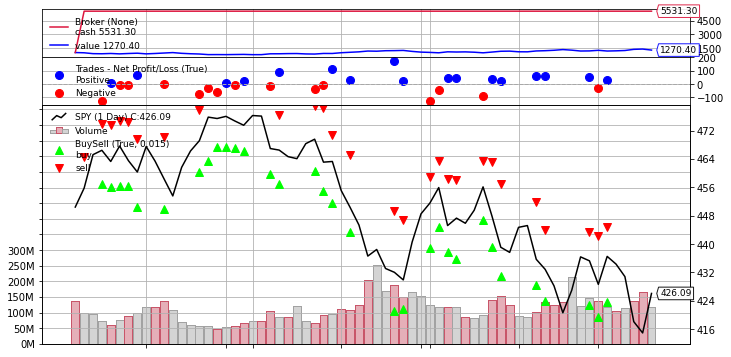

[[<Figure size 720x360 with 4 Axes>]]

In [85]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]
cerebro.plot(start=datetime.date(2021, 12, 1), end=datetime.date(2022, 3, 10), iplot=False)